In [ ]:
# Author: Ian Dirk Fichtner
# Lastest update: 2022-12-16
# Email: ifichtner@protonmail.com

In [64]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, morphology, transform
import scanpy as sc
import anndata as ad
import squidpy as sq

import warnings
warnings.filterwarnings('ignore')

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
# sc.settings.set_figure_params(dpi=80, facecolor='white')

# Includes inspiration from:
# Lotte Polaris
#     - ~/scratch/datasets/stereoSeq/readme.md
#     - ~/scratch/datasets/stereoSeq/StereoSeqPointers.ipynb
# Squidpy tutorials:
#     - https://squidpy.readthedocs.io/en/stable/

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.2.0 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.8


# To-dos
 - integrate both the spots and image into the same coordinate space correctly
 - group observations according to segmentation mas to obtian pseudo-cells
 - do single-cell downstream analsis on pseudo-cells
 - apply more segmentation methods
 - apply same script to more datasets
 - evaluate process of integration into `TXsim` pipeline

# Define some variables

In [2]:
path_root = '/home/jovyan'
path_datasets = os.path.join(path_root, 'scratch/datasets/stereoSeq/')

path_BGIResearch = os.path.join(path_datasets, 'BGIResearch-2022')
path_data_BGI = os.path.join(path_BGIResearch, 'converted_SS200000135TL_D1.h5ad')
path_result_BGI = 'output/BGIResearch-2022/adata_BGI.h5ad'

# Import and format data

In [3]:
adata = ad.read_h5ad(path_data_BGI)
adata

AnnData object with n_obs × n_vars = 8119736 × 22413
    obs: 'x_coords', 'y_coords'
    var: 'gene_name'

In [4]:
adata.obs = adata.obs.apply(pd.to_numeric)
adata.obsm['spatial'] = adata.obs.loc[:, ['x_coords', 'y_coords']].to_numpy()
adata.var_names = adata.var['gene_name']
adata

AnnData object with n_obs × n_vars = 8119736 × 22413
    obs: 'x_coords', 'y_coords'
    var: 'gene_name'
    obsm: 'spatial'

# Image integration

In [83]:
path_image = os.path.join(path_BGIResearch, 'SS200000135TL_D1_regist.tif') #insert the path to the file
image = io.imread(path_image) # to read in the image, that then is a np array that can be used directly
image = transform.rotate(image, 180)
image = image[:, ::-1]

crop image

In [84]:
offset=[5000, 21000, 1000, 17000]
image = image[offset[0]:offset[1],offset[2]:offset[3]]

Visualize this image 

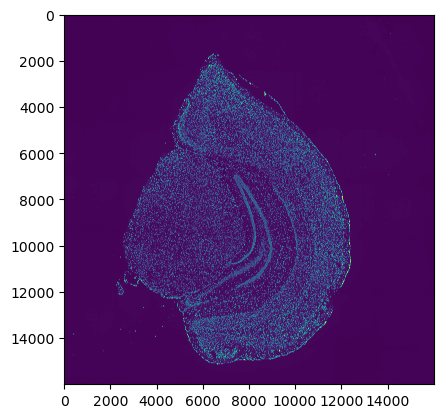

In [85]:
plt.imshow(image)

Create `adata.uns['spatial']`

In [106]:
adata.uns['spatial'] = {
    
    'SS200000135TL': {
        
        'images': {
            
            'hires': image
            
        },
        
        'scalefactor': {
            
            'spot_diameter_fullres': 5,
            'tissue_hires_scalef': 1 
            
        }
        
    }
    
}

adata.obs['library_id'] = 'SS200000135TL' * adata.n_obs

In [ ]:
# The following chunk not executing indicates that something went wrong.
# Todo: integrate both the spots and image into the same coordinate space correctly.

In [ ]:
plt.scatter(x = adata.obs['x_coords'] - 1000 , y=adata.obs['y_coords'] - 5000)
plt.xlim(0, 16000)
plt.ylim(0, 16000)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# Plots

In [ ]:
sq.pl.spatial_scatter(adata, color=['Cabra1'], library_key='library_id')

In [90]:
adata.var_names

Index(['Gm42418', 'Camk1d', 'Gabra1', 'Cmss1', 'Purb', 'Ptgds', 'Gphn', 'Cdk8',
       'Fth1', 'Mllt3',
       ...
       'Mrgpra2b', 'Gm48829', 'Gm13203', 'Ccr1', 'Gm44787', 'Gm10067',
       '9430093N23Rik', 'Olfr1431', '9230102K24Rik', 'Gm29040'],
      dtype='object', name='gene_name', length=22413)

# Segmentation

In [98]:
# Add the image
ic = sq.im.ImageContainer(image)
ic

Adding image layer `image`


ImageContainer[shape=(16000, 16000), layers=['image']]

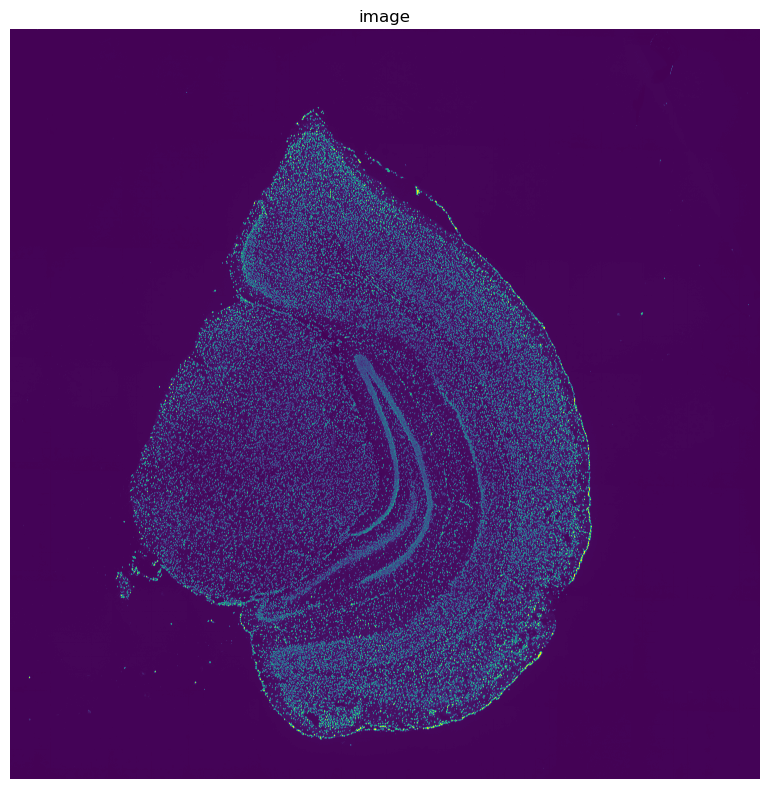

In [99]:
# Visualize
ic.show("image")

In [100]:
# Segment using "watershed" method with "otsu" automatic thresholding
sq.im.segment(img=ic, layer="image", channel=0, method="watershed", thresh=None, geq=True)

Segmenting an image of shape `(16000, 16000, 1, 1)` using `SegmentationWatershed`
Adding image layer `image`
Finish (0:05:10)
Adding image layer `segmented_watershed`


ImageContainer[shape=(16000, 16000), layers=['image', 'segmented_watershed']]
Number of segments in crop: 113141


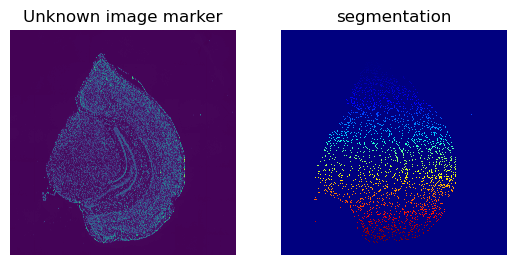

In [102]:
print(ic)
print(f"Number of segments in crop: {len(np.unique(ic['segmented_watershed']))}")

fig, axes = plt.subplots(1, 2)
ic.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
ic.show("segmented_watershed", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")


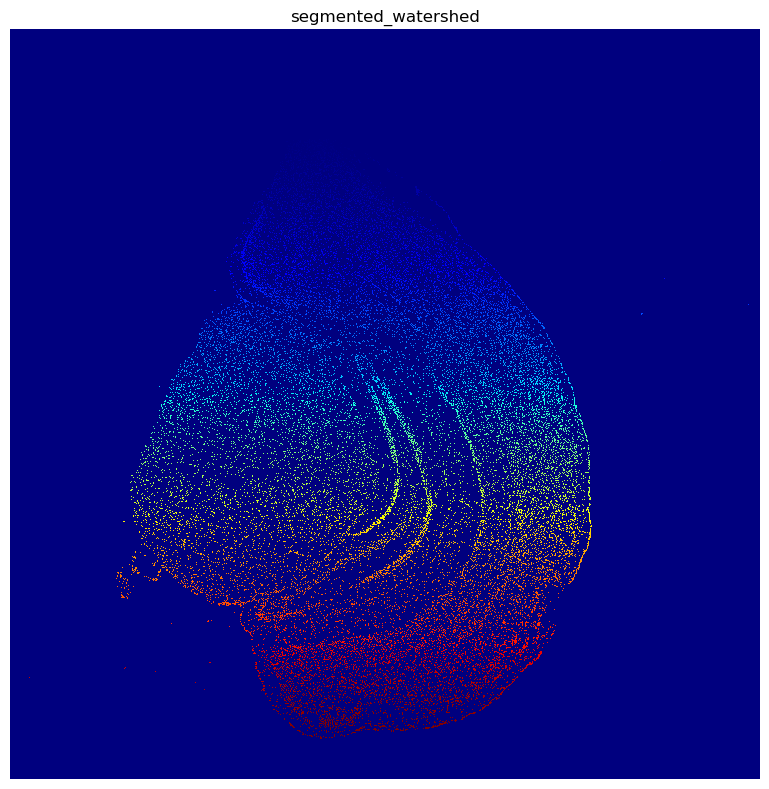

In [103]:
ic.show("segmented_watershed", cmap="jet", interpolation="none")

# Single cell level analysis

Structure already prepared. Possible small adjustments needed

### Observations grouping based on segmentation mask

Thi does require coding

## Preprocessing

### QC

Genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


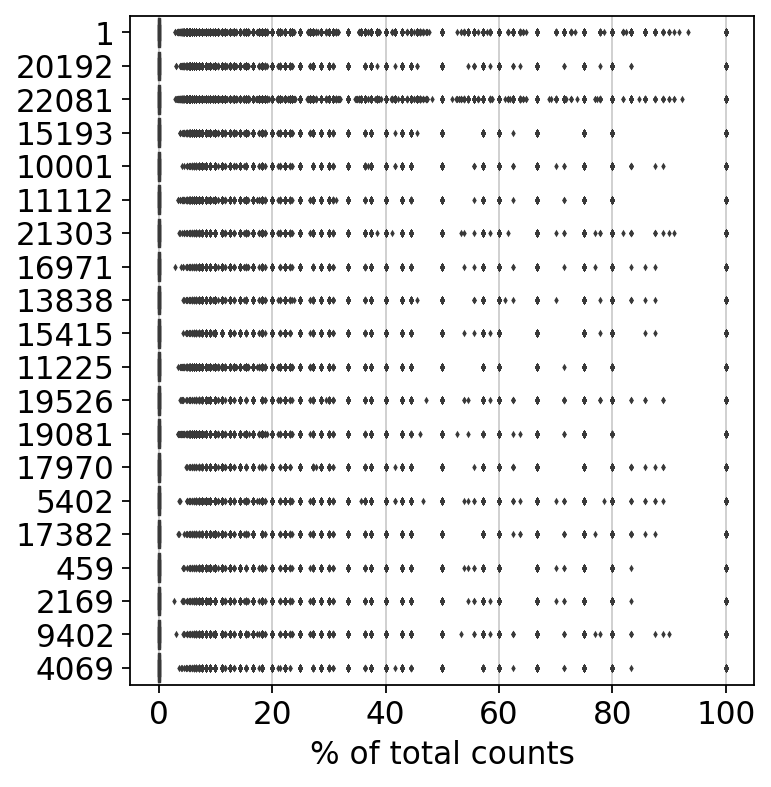

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20)

No mitocondrial genes?

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['mt'].sum()

0

Count depth histogramm

<AxesSubplot: ylabel='Frequency'>

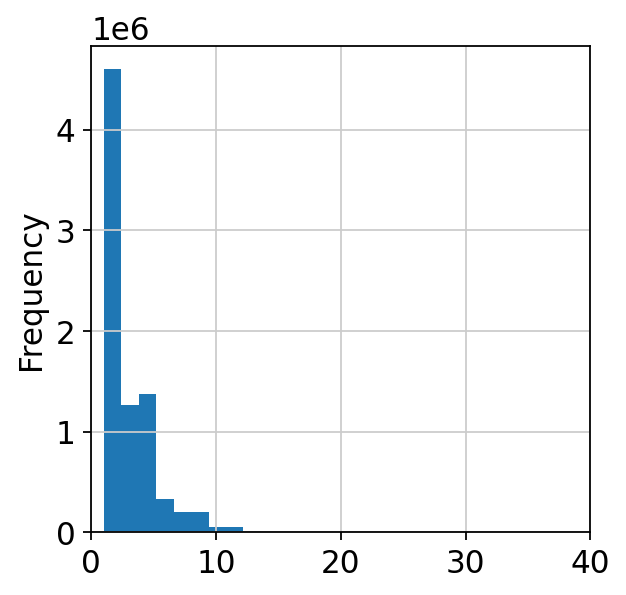

In [11]:
cd = adata.to_df().sum(axis=1)
cd.plot.hist(bins=20, xlim=[0, 20])

### Count depth ranked

In [13]:
cdr = adata.to_df().sum(axis=1)
# plt.scatter(cdr.iloc[:, 0])

### Genes per cell

In [ ]:
pd.DataFrame(adata.to_df()>0).sum(axis=1).plot.hist(bins=50)

### QC metric using scanpy

In [5]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

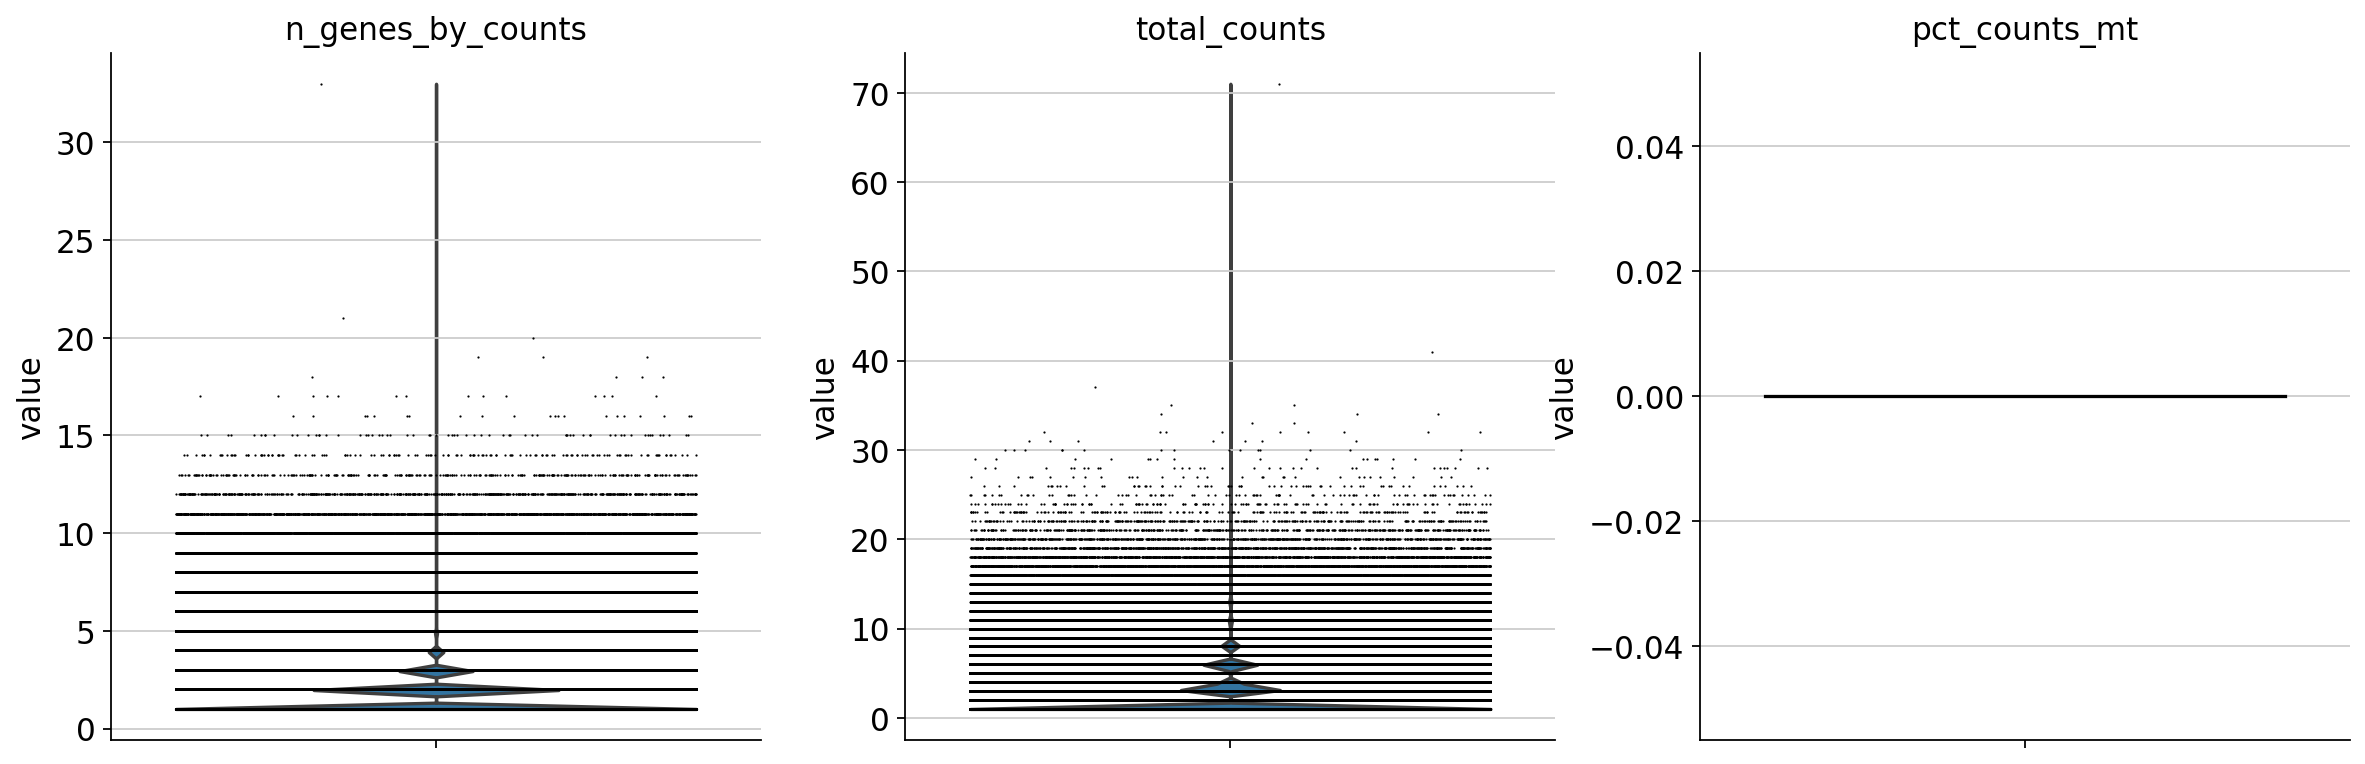

In [6]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)



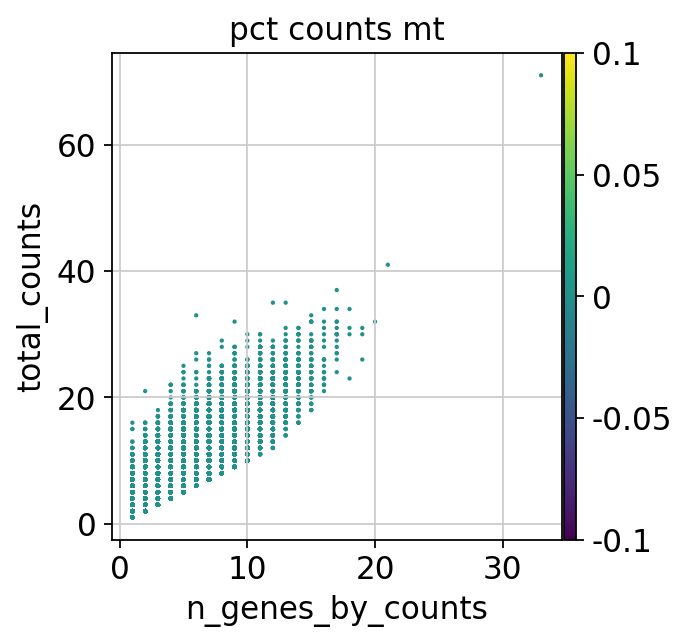

In [10]:
sc.pl.scatter(adata, x='n_genes_by_counts', y='total_counts', color='pct_counts_mt', size=15)

Filtering on cell level

In [ ]:
adata[adata.obs['total_counts'] > 3, :]
adata[adata.obs['n_genes_by_counts'] > 0, :]
adata[adata.obs['pct_counts_mt'] > 0, :]

Cells per gene

In [ ]:
pd.DataFrame(adata.to_df() > 0).sum(axis=0).plot.hist(bins=75)

Filtering on gene level

In [ ]:
sc.pp.filter_genes(adata, min_cells=0)

### Save the data

In [45]:
ad.write('path_result_BGI')